In [3]:
import praw
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime, timezone
import re

In [4]:
%run reddit_credentials.py

In [5]:
# Reddit API credentials (replace with your own)
reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent
)

In [6]:
def fetch_reddit_topics_and_subreddits(subreddit='all', limit=5000):
    data = []
    current_year = datetime.utcnow().year
    
    for submission in reddit.subreddit(subreddit).top(limit=limit, time_filter='all'):
        post_year = pd.to_datetime(submission.created_utc, unit='s').year
        if post_year >= current_year - 10:
            # Extract topics and subreddits formatted as "r/<topic>" in title or post
            title_topics = re.findall(r'r/\w+', submission.title)
            body_topics = re.findall(r'r/\w+', submission.selftext)
            topics = list(set(title_topics + body_topics))
            
            # Track subreddit
            subreddit_name = submission.subreddit.display_name
            
            if topics:
                for topic in topics:
                    data.append([topic.lower(), post_year, subreddit_name])  # Normalize to lowercase
    
    return pd.DataFrame(data, columns=['Topic', 'Year', 'Subreddit'])

In [ ]:
df = fetch_reddit_topics_and_subreddits(subreddit='all', limit=5000)

In [5]:
df.to_csv("reddit_df.csv")

In [6]:
# Aggregate topic and subreddit trends per year
topic_counts = df.groupby(['Year', 'Topic']).size().reset_index(name='Topic Count')
subreddit_counts = df.groupby(['Year', 'Subreddit']).size().reset_index(name='Subreddit Count')

# Pivot for visualization (topics and subreddits)
df_topics = topic_counts.pivot(index='Year', columns='Topic', values='Topic Count').fillna(0)
df_subreddits = subreddit_counts.pivot(index='Year', columns='Subreddit', values='Subreddit Count').fillna(0)

In [7]:
df_topics.to_csv("topics.csv")
df_subreddits.to_csv("subreddits.csv")

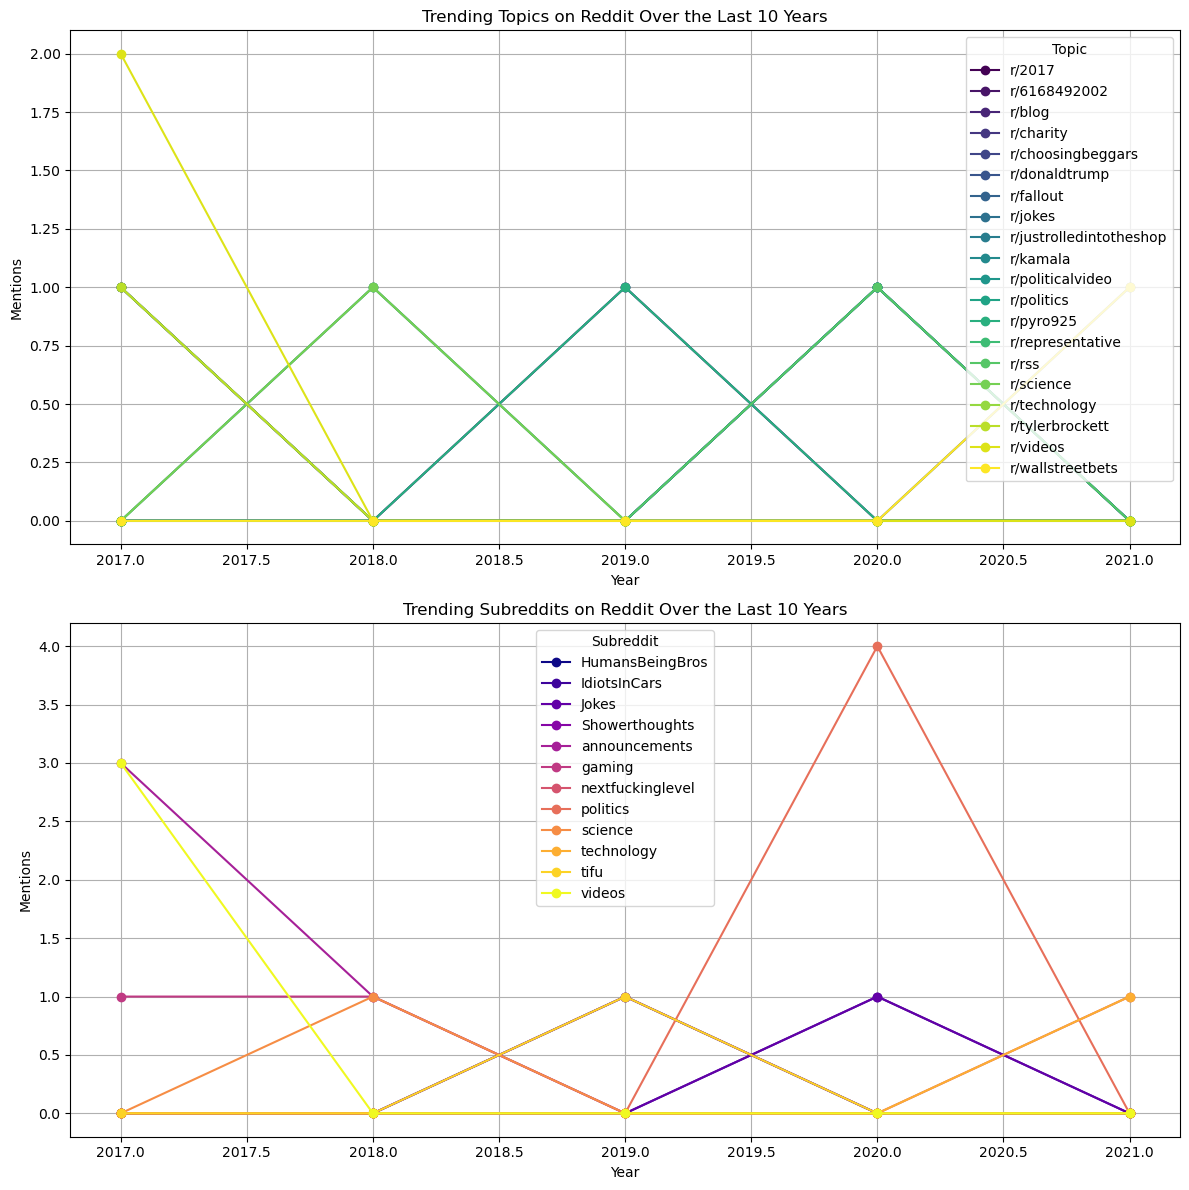

In [8]:
# Plot historical trends (topics and subreddits)
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

df_topics.plot(kind='line', marker='o', colormap='viridis', ax=axes[0])
axes[0].set_title("Trending Topics on Reddit Over the Last 10 Years")
axes[0].set_ylabel("Mentions")
axes[0].set_xlabel("Year")
axes[0].grid()

df_subreddits.plot(kind='line', marker='o', colormap='plasma', ax=axes[1])
axes[1].set_title("Trending Subreddits on Reddit Over the Last 10 Years")
axes[1].set_ylabel("Mentions")
axes[1].set_xlabel("Year")
axes[1].grid()

plt.tight_layout()
plt.show()